In [9]:
import json
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def filter_df(df, num_sources=None, num_targets=None):
    """
    A function to filter the data frame by top n sources and targets
    If num_sources or num_targets args are not supplied, they will not be filtered
    """
    if num_targets:
        top_targets = df.sum().sort_values(ascending=False)
        df = df[top_targets[:num_targets].index]
    
    if num_sources:
        top_sources = df.sum(axis=1).sort_values(ascending=False)[:num_sources]
        df = df.loc[top_sources.index]
    
    return df


def create_sankey_df(df, min_val=0):
    """
    Create the human-readable form of the Sankey chart data from an input data frame
    Data can be filtered by a threshold minimum value
    | Source | Source Value | Target | Target Value |
    |    A   |      5       |   i    |      3       |
    |    A   |      5       |   j    |      2       |
    |    B   |      7       |   i    |      1       |
    |    B   |      7       |   k    |      4       |
    """
    
    sources = []
    source_vals = []
    targets = []
    target_vals = []
    for source_name in df.index:
        row = df.loc[source_name]
        sources += [source_name] * sum(row.values > min_val)
        source_vals += [row[row.values > min_val].sum()] * sum(row.values > min_val)
        targets += list(row[row > min_val].index)
        target_vals += list(row[row > min_val].values)
    
    sankey_df = pd.DataFrame({
        'source': sources,
        'target': targets,
        'value': target_vals
    })
    
    return sankey_df


def create_label_dict(node_df, start_idx=0):
    """
    Return a dictionary with labels as keys and indices as values.  Applied 
    to each section of the flow visualization (two nodes and an edge). The
    `node_df` represents each section.
    """
    labels = set(node_df.source).union(node_df.target)
    sorted_labels = sorted(list(labels))
    return {sorted_labels[i]: i + start_idx for i in range(len(sorted_labels))}


def create_final_list(node_df, node_label_dict):
    """
    Return a list of dictionaries and the labels for each section of the flow 
    diagram.
    """
    df = pd.DataFrame({
        "source": node_df.source.map(node_label_dict),
        "target": node_df.target.map(node_label_dict),
        "value" : node_df.value
    })
    
    labels = list(node_label_dict.keys())
    return df.to_dict("records"), labels

In [3]:
investor = pd.read_excel(
    "../data/Equity investor SUP matrix.xlsx",
    engine="openpyxl",
    skiprows=3,
    usecols="B, E:GG",
)

investor = investor.rename(columns={investor.columns[0]: "Ultimate Investor"})

# drop last row because it is a table summary
investor = investor[:-1]
investor = investor.set_index('Ultimate Investor')

# Set the value of Kingdom of Saudi Arabia investment in Saudi Arabian Oil company to equal
# the second largest investment
investor.loc['KINGDOM OF SAUDI ARABIA', ('Saudi Arabian Oil Co')] = investor.max(axis=0).sort_values(ascending=False)[1]

In [4]:
financer = pd.read_excel(
    "../data/Financing SUP matrix.xlsx",
    engine="openpyxl",
    skiprows=4,
    usecols="A:AV",
)

# drop last row because it is null
financer = financer[:-1]
financer = financer.set_index('Bank')

In [5]:
producer = pd.read_excel(
    "../data/MFA matrix.xlsx",
    sheet_name="Conversion",
    engine="openpyxl",
    skiprows=1,
    usecols="C:FY",
).dropna()

producer = producer.groupby('Producer').sum()

In [6]:
waste = pd.read_excel(
    "../data/MFA matrix.xlsx",
    sheet_name="Waste",
    engine="openpyxl",
    skiprows=1,
    usecols="B, D:FY",
).dropna()

waste = waste.groupby('Country').sum()

In [7]:
destination = pd.read_excel(
    "../data/MFA matrix.xlsx",
    sheet_name="Waste",
    engine="openpyxl",
    skiprows=1,
    usecols="C:FY",
).dropna()

destination = destination.groupby('Producer').sum()

In [8]:
investor_df = create_sankey_df(investor)
financer_df = create_sankey_df(financer)
producer_df = create_sankey_df(producer)
waste_df = create_sankey_df(waste)
destination_df = create_sankey_df(destination)

In [11]:
with open('../data/region_map.json', 'r') as f:
    region_dict = json.load(f)
country_to_region = { country['name']: country['region'] for country in region_dict }

In [12]:
# Assign regions to countries
region = [country_to_region[country] for country in destination_df['target']]
destination_df['region'] = region
destination_df.head()

,source,target,value,region
0,ABU DHABI NATIONAL OIL COMPANY (ADNOC),Algeria,1.206092,Africa
1,ABU DHABI NATIONAL OIL COMPANY (ADNOC),Argentina,0.001858,Americas
2,ABU DHABI NATIONAL OIL COMPANY (ADNOC),Australia,14.574030,Oceania
3,ABU DHABI NATIONAL OIL COMPANY (ADNOC),Austria,1.739902,Europe
4,ABU DHABI NATIONAL OIL COMPANY (ADNOC),Bahrain,1.245451,Asia


# Top Producer Bar Plot

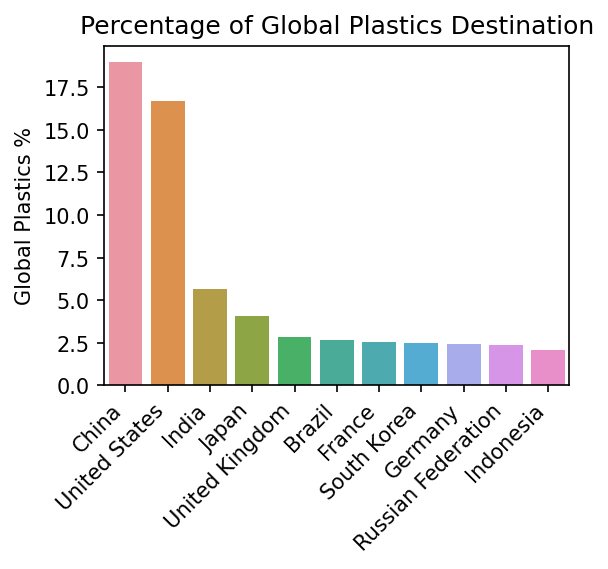

In [123]:
plt.figure(figsize=(4,3), dpi=150, facecolor=(1,1,1))
country_sum = destination_df.groupby('target').sum().sort_values(by='value', ascending=False)[:11].reset_index()
country_sum['percentage'] = country_sum['value'] /  destination_df.groupby('target').sum()['value'].sum() * 100
sns.barplot(x='target', y='percentage', data=country_sum)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Global Plastics %')
plt.xlabel('')
plt.title('Percentage of Global Plastics Destination')
plt.show()

# Number of Export Countries for Top Producers
Top producers send plastics everywhere

In [131]:
top_producers = list(destination_df.groupby('source').sum().sort_values(by='value', ascending=False).iloc[:11].index)

In [132]:
num_countries = []
for producer in top_producers:
    num_countries.append(len(destination_df[destination_df['source'] == producer]))

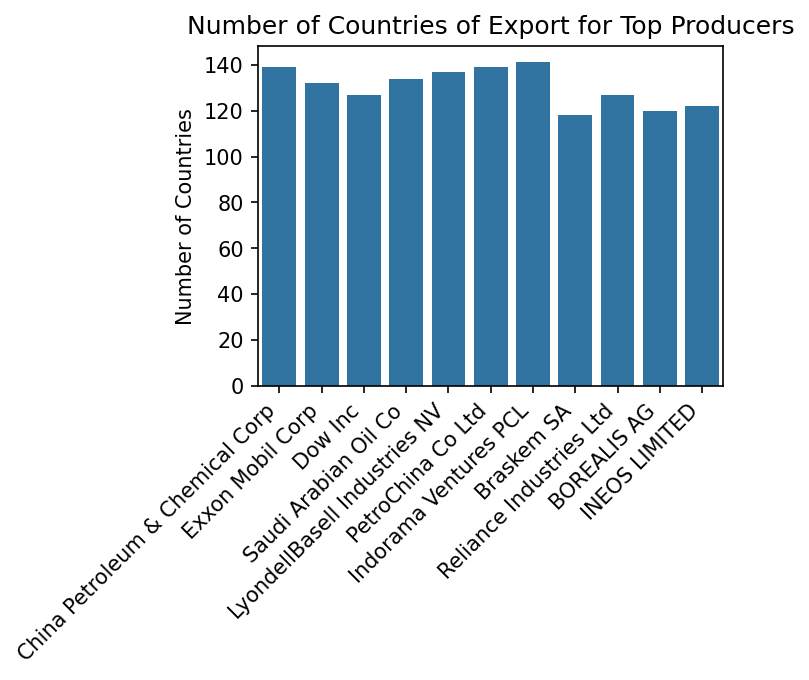

In [133]:
plt.figure(figsize=(4,3), dpi=150, facecolor=(1,1,1))
sns.barplot(x=top_producers, y=num_countries, color='C0')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.title('Number of Countries of Export for Top Producers')
plt.ylabel('Number of Countries')
plt.show()

# Histogram of Number of Export Countries
Most producers send plastics indiscriminately across the globe

In [135]:
top_producers = list(destination_df.groupby('source').sum().sort_values(by='value', ascending=False).index)
num_countries = []
for producer in top_producers:
    num_countries.append(len(destination_df[destination_df['source'] == producer]))

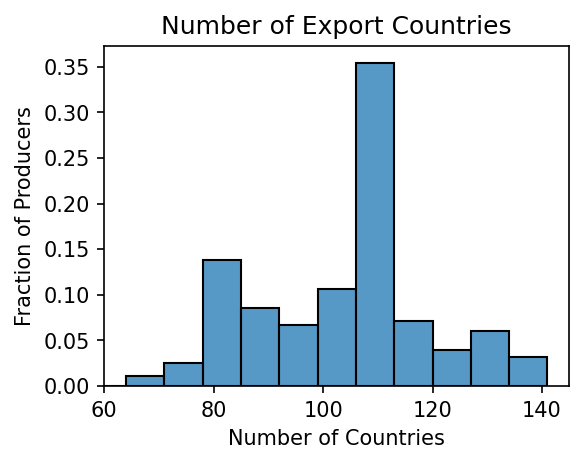

In [136]:
plt.figure(figsize=(4,3), dpi=150, facecolor=(1,1,1))
sns.histplot(num_countries, bins=20, stat='probability')
plt.xlim([60, 145])
plt.xlabel('Number of Countries')
plt.ylabel('Fraction of Producers')
plt.title('Number of Export Countries')
plt.show()

# Per-Capita Plastics

In [100]:
with open('../data/country_population.json', 'r') as f:
    population = json.load(f)

pop_countries = np.array([element['country'] for element in population])
populations = np.array([element['population'] for element in population])

In [122]:
# Assign population to countries
country_total = destination_df.groupby('target').sum()
country_total['population'] = [np.squeeze(populations[pop_countries == country]) for country in country_total.index]
country_total['per capita'] = country_total['value'] / country_total['population'] * 1000000
country_total = country_total.sort_values(by='per capita', ascending = False)

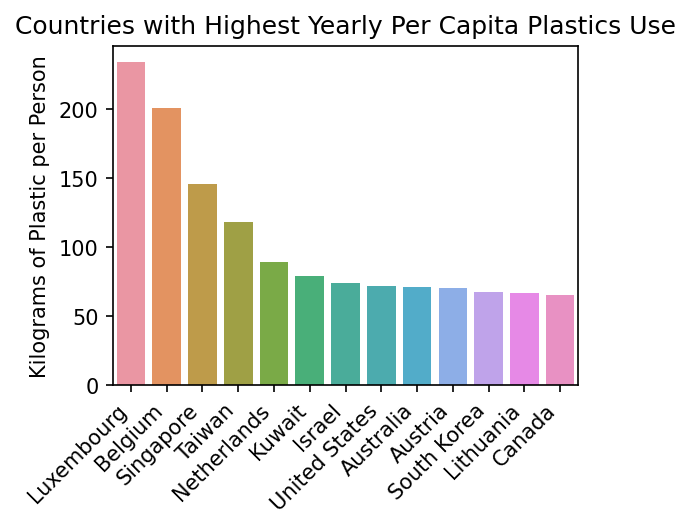

In [127]:
plt.figure(figsize=(4,3), dpi=150, facecolor=(1,1,1))
sns.barplot(x=country_total.index[:13], y=country_total['per capita'][:13])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Kilograms of Plastic per Person')
plt.xlabel('')
plt.title('Countries with Highest Yearly Per Capita Plastics Use')
plt.show()

# Distribution of Per-Capita Plastics Use by Country
Most countries don't use that much plastic per person

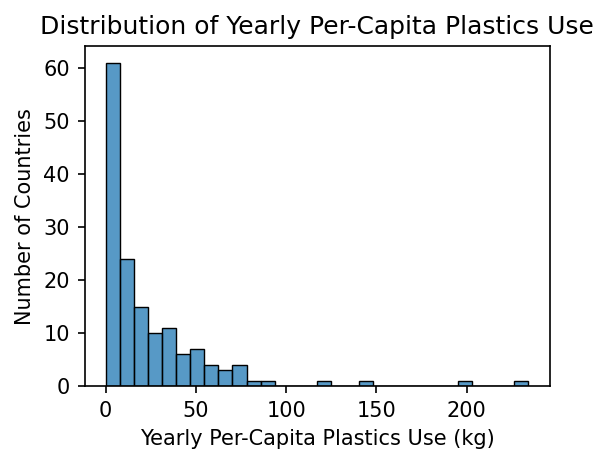

In [128]:
plt.figure(figsize=(4,3), dpi=150, facecolor=(1,1,1))
sns.histplot(data=country_total, x='per capita', bins=30)
plt.ylabel('Number of Countries')
plt.xlabel('Yearly Per-Capita Plastics Use (kg)')
plt.title('Distribution of Yearly Per-Capita Plastics Use')
plt.show()